# Business Analysis of Movie Data
### By: Christian Tsui


## Import Packages

In [1]:
# Your code here - remember to use markdown cells for comments as well!
# Connecting to the Database
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
import requests
import time
import plotly.express as px
from bs4 import BeautifulSoup
%matplotlib inline


## Load & Preview Dataset

In [2]:
gross_csv = "./zippedData/bom.movie_gross.csv.gz"
imdb_zip = "./zippedData/im.db"
info_tsv = "./zippedData/rt.movie_info.tsv.gz"
reviews_tsv = "./zippedData/rt.reviews.tsv.gz"
tmdb_csv = "./zippedData/tmdb.movies.csv.gz"
budgets_csv = "./zippedData/tn.movie_budgets.csv.gz"

In [3]:
movie_gross_df = pd.read_csv(gross_csv)
movie_info_df = pd.read_csv(info_tsv, delimiter='\t')
movie_reviews_df = pd.read_csv(reviews_tsv, delimiter='\t', encoding='latin-1')
tmdb_df = pd.read_csv(tmdb_csv)
budgets_df = pd.read_csv(budgets_csv)

# Question 1: What genre of movies are the most successful?

This question explores the idea of what genre of movies are the best performing in the box office based off of Return on Investment (ROI). I am using ROI as the measure of success because it is a popular performance metric that evaluates the efficiency of different investments. If there are trends that indicate certain genres are more successful, Microsoft should consider allocating their resources to producting movies with those specific themes.

## Method:

### Read in Imdb Data

In [4]:
# Connecting to the Database
conn = sqlite3.connect("./zippedData/im.db")

# Viewing the list of tables
imdb_tables = pd.read_sql("""SELECT name FROM sqlite_master WHERE type = 'table';""", conn)
imdb_tables

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


### Inspecting the Imdb Data

In [5]:
# Previewing the data
pd.read_sql("""
SELECT * FROM movie_basics
LIMIT 5;""", conn)

# Creating a variable
imdb_basics = pd.read_sql("""SELECT * FROM movie_basics;""", conn)

# Inspecting the data types, missing values
imdb_basics.info()

imdb_basics.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


,start_year,runtime_minutes
count,146144.000000,114405.000000
mean,2014.621798,86.187247
std,2.733583,166.360590
min,2010.000000,1.000000
25%,2012.000000,70.000000
50%,2015.000000,87.000000
75%,2017.000000,99.000000
max,2115.000000,51420.000000


### Cleaning the Imdb Basics Table

In [6]:
# For a large dataset, dropping missing values is appropriate
imdb_basics.dropna(inplace=True)

# Looking at the 'genres' column, we have to separate the genres in order to correctly categorize the movies
# Seperating the genres into multiple genres
imdb_basics['genres'] = imdb_basics['genres'].apply(lambda x: x.split(','))

In [7]:
# Create a new column containing the first genre
imdb_basics['main_genre'] = imdb_basics['genres'].apply(lambda x: x[0])

In [8]:
# Resetting columns
imdb_basics.drop(['movie_id','original_title'], axis=1)

,primary_title,start_year,runtime_minutes,genres,main_genre
0,Sunghursh,2013,175.0,"[Action, Crime, Drama]",Action
1,One Day Before the Rainy Season,2019,114.0,"[Biography, Drama]",Biography
2,The Other Side of the Wind,2018,122.0,[Drama],Drama
4,The Wandering Soap Opera,2017,80.0,"[Comedy, Drama, Fantasy]",Comedy
5,A Thin Life,2018,75.0,[Comedy],Comedy
...,...,...,...,...,...
146134,Drømmeland,2019,72.0,[Documentary],Documentary
146135,The Rehearsal,2019,51.0,[Drama],Drama
146136,Illenau - die Geschichte einer ehemaligen Heil...,2017,84.0,[Documentary],Documentary
146137,Safeguard,2019,90.0,"[Drama, Thriller]",Drama


In [9]:
imdb_clean = imdb_basics.loc[:,['primary_title','main_genre']]
imdb_clean

,primary_title,main_genre
0,Sunghursh,Action
1,One Day Before the Rainy Season,Biography
2,The Other Side of the Wind,Drama
4,The Wandering Soap Opera,Comedy
5,A Thin Life,Comedy
...,...,...
146134,Drømmeland,Documentary
146135,The Rehearsal,Drama
146136,Illenau - die Geschichte einer ehemaligen Heil...,Documentary
146137,Safeguard,Drama


### Inspect the Gross Revenue Data

In [10]:
movie_gross_df.head(3)

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010


In [11]:
# As you can see there is missing data ('studio', 'domestic_gross', 'foreign_gross')
# 'foreign_gross' is also listen as an object, so I would like to convert it to a float
movie_gross_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


### Cleaning the Gross Revenue Dataset

In [12]:
# Dropping missing values to maintain uifomity in the dataset
movie_gross_df.dropna(inplace=True)
movie_gross_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2007 entries, 0 to 3353
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           2007 non-null   object 
 1   studio          2007 non-null   object 
 2   domestic_gross  2007 non-null   float64
 3   foreign_gross   2007 non-null   object 
 4   year            2007 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 94.1+ KB


In [13]:
# Convert relavent data to float to provide consistency
# Removing punctuation in the string, converting to float
movie_gross_df['foreign_gross'] = movie_gross_df['foreign_gross'].str.replace(',','').astype(float)

In [14]:
# Creating a 'total_gross' column
movie_gross_df['total_gross'] = movie_gross_df['domestic_gross'] + movie_gross_df['foreign_gross']
movie_gross_df = movie_gross_df.loc[:,['title','total_gross','year']]
movie_gross_df.head(3)

,title,total_gross,year
0,Toy Story 3,1.067000e+09,2010
1,Alice in Wonderland (2010),1.025500e+09,2010
2,Harry Potter and the Deathly Hallows Part 1,9.603000e+08,2010


In [15]:
# Checking to see data types
movie_gross_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2007 entries, 0 to 3353
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   title        2007 non-null   object 
 1   total_gross  2007 non-null   float64
 2   year         2007 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 62.7+ KB


In [16]:
# Information shows the dataset is from year 2010 to 2018
movie_gross_df.describe()

,total_gross,year
count,2.007000e+03,2007.000000
mean,1.228102e+08,2013.506228
std,2.075562e+08,2.597997
min,4.900000e+03,2010.000000
25%,8.239000e+06,2011.000000
50%,4.240000e+07,2013.000000
75%,1.337500e+08,2016.000000
max,1.518900e+09,2018.000000


### Merging Gross Revenue Table with Genre Table

In [17]:
# Using merge to combine tables
gross_genre = movie_gross_df.merge(imdb_clean, how = 'left', left_on='title', right_on='primary_title')

In [18]:
gross_genre.head(3)

,title,total_gross,year,primary_title,main_genre
0,Toy Story 3,1.067000e+09,2010,Toy Story 3,Adventure
1,Alice in Wonderland (2010),1.025500e+09,2010,NaN,NaN
2,Harry Potter and the Deathly Hallows Part 1,9.603000e+08,2010,NaN,NaN


### Inspecting the Movie Budgets Data

In [19]:
budgets_df.head(3)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"


In [20]:
# Displaying the data information, looking for missing values, data types
budgets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


### Cleaning the Budgets Data

In [21]:
budgets_df['release_date'] = pd.to_datetime(budgets_df['release_date'])

In [22]:
# extracting the relevant information
budgets_clean = budgets_df.loc[:,['release_date','movie','production_budget', 'domestic_gross', 'worldwide_gross']]

In [23]:
budgets_clean.head(3)

,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,2009-12-18,Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2011-05-20,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,2019-06-07,Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"


In [24]:
# Cleaning 'production_budget' column (converting to str, removing any punctuation, converting to float)
budgets_clean['production_budget'] = budgets_clean['production_budget'].str.replace('$','')
budgets_clean['production_budget'] = budgets_clean['production_budget'].str.replace(',','').astype(float)

In [25]:
# Cleaning 'domestic_gross' column (converting to str, removing any punctuation, converting to float)
budgets_clean['domestic_gross'] = budgets_clean['domestic_gross'].str.replace('$','')
budgets_clean['domestic_gross'] = budgets_clean['domestic_gross'].str.replace(',','').astype(float)


In [26]:
# Cleaning 'worldwide_gross' column (converting to str, removing any punctuation, converting to float)
budgets_clean['worldwide_gross'] = budgets_clean['worldwide_gross'].str.replace('$','')
budgets_clean['worldwide_gross'] = budgets_clean['worldwide_gross'].str.replace(',','').astype(float)

In [27]:
# Adding column for international gross, as worldwide gross can be misleading
budgets_clean['international_gross'] = budgets_clean['worldwide_gross'] - budgets_clean['domestic_gross']
# Rearranging columns in the dataset
budgets_clean = budgets_clean.loc[:,['release_date','movie','production_budget','domestic_gross','international_gross','worldwide_gross']]


In [28]:
# Adding a column calculating 'ROI'
budgets_clean['roi'] = (((budgets_clean.worldwide_gross - budgets_clean.production_budget)/budgets_clean.production_budget)* 100).round(2)

In [29]:
# Now that the data is uniform and cleaned, we can look at the statistical data
budgets_clean.describe()

,production_budget,domestic_gross,international_gross,worldwide_gross,roi
count,5.782000e+03,5.782000e+03,5.782000e+03,5.782000e+03,5782.000000
mean,3.158776e+07,4.187333e+07,4.961413e+07,9.148746e+07,380.016166
std,4.181208e+07,6.824060e+07,1.131192e+08,1.747200e+08,2953.028211
min,1.100000e+03,0.000000e+00,0.000000e+00,0.000000e+00,-100.000000
25%,5.000000e+06,1.429534e+06,0.000000e+00,4.125415e+06,-50.770000
50%,1.700000e+07,1.722594e+07,5.701766e+06,2.798445e+07,70.830000
75%,4.000000e+07,5.234866e+07,4.682110e+07,9.764584e+07,275.832500
max,4.250000e+08,9.366622e+08,2.015838e+09,2.776345e+09,179900.000000


In [30]:
budgets_clean.reset_index()

,index,release_date,movie,production_budget,domestic_gross,international_gross,worldwide_gross,roi
0,0,2009-12-18,Avatar,425000000.0,760507625.0,2.015838e+09,2.776345e+09,553.26
1,1,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,8.046000e+08,1.045664e+09,154.67
2,2,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.070000e+08,1.497624e+08,-57.21
3,3,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,9.440081e+08,1.403014e+09,324.38
4,4,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,6.965404e+08,1.316722e+09,315.37
...,...,...,...,...,...,...,...,...
5777,5777,2018-12-31,Red 11,7000.0,0.0,0.000000e+00,0.000000e+00,-100.00
5778,5778,1999-04-02,Following,6000.0,48482.0,1.920130e+05,2.404950e+05,3908.25
5779,5779,2005-07-13,Return to the Land of Wonders,5000.0,1338.0,0.000000e+00,1.338000e+03,-73.24
5780,5780,2015-09-29,A Plague So Pleasant,1400.0,0.0,0.000000e+00,0.000000e+00,-100.00


### Final Gross Revenue, Budget, and Genre Dataframe

In [31]:
gross_genre_budget = gross_genre.merge(budgets_clean, how='left', left_on='title', right_on='movie')
gross_genre_budget = gross_genre_budget.drop_duplicates('title').sort_values('roi', ascending=False)

In [32]:
gross_genre_budget.dropna(inplace=True)

In [33]:
genre_roi_df = gross_genre_budget.loc[:,['title','main_genre','roi']]

In [34]:
genre_roi_df = genre_roi_df.iloc[2:]

In [35]:
# ROI, worldwide_gross, and production_budget grouped by genre, sorting values by 'ROI'
genre_roi_df = genre_roi_df.groupby('main_genre').mean().sort_values(by='roi', ascending=False)

In [36]:
genre_roi_df.reset_index(inplace=True)

# Question 1 Analysis:

## Average ROI by Genre

This figure plots the average Return on Investment (ROI), grouped by Genre. The data suggests that within 2010 - 2018, the top three genres with the highest average ROI are Horror, Mystery, and Drama. 

/Users/ChristianTsui/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


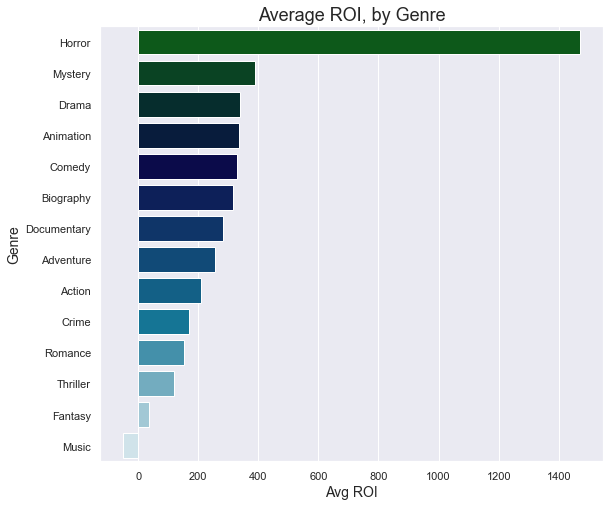

In [37]:
sns.set(rc={'figure.figsize':(9,8)})
plot = sns.barplot('roi','main_genre' , data = genre_roi_df, order= genre_roi_df['main_genre'], palette='ocean');
plot.set_title('Average ROI, by Genre',fontsize=18);
plt.xlabel('Avg ROI', fontsize=14);
plt.ylabel('Genre', fontsize=14);

## Total Gross Revenue by Genre

This graph represents Gross Revenue categorized by genre. As you can see, Action, Adventure, and Comedy are the top three highest grossing genres.

In [38]:
# Displaying relevant data, group by genre, sum total_gross, sort by total gross
gross_genre = gross_genre.groupby(['main_genre'])['total_gross'].sum().reset_index().sort_values('total_gross', ascending=False)

/Users/ChristianTsui/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


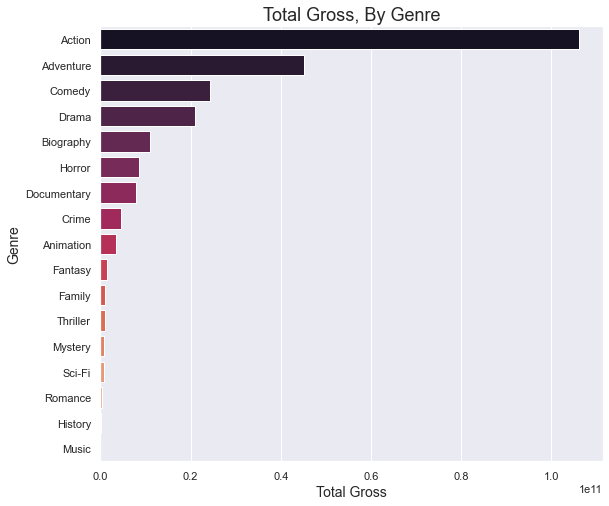

In [39]:
sns.set(rc={'figure.figsize':(9,8)})
plot = sns.barplot('total_gross','main_genre' , data = gross_genre, order= gross_genre['main_genre'], palette='rocket');
plot.set_title('Total Gross, By Genre',fontsize=18);
plt.xlabel('Total Gross', fontsize=14);
plt.ylabel('Genre', fontsize=14);

# Question 1 Conclusion:

The figures show that the genres with the highest ROI are slightly different than the genres with the highest total gross. The genres with the highest ROI are Horror, Mystery, and Drama. The highest grossing genres are Action, Adventure, and Comedy. Since Microsoft is new to the movie production industry, I would suggest that Microsoft pursue movies with the highest ROI. This is because capital risk would be lower, and potential for return is significantly higher.

# Question 2: What is the run-time and release date (seasonality) associated with the best performing genres?

In this question, I am looking at the run-time and release date (seasonality) for the movies with the highest ROI (Return-On-Investment). If the most successful genres have a certain run-time, then Microsoft should make movies within that time period. Additionally, if the most successful genres tend to release movies during a specific time of the year, then Microsoft should consider the seasonality as well.

## Method:

### Constructing Runtime and Genre Dataframe

In [40]:
gross_genre_budget = gross_genre_budget.iloc[2:]

In [41]:
runtime_horror_df = gross_genre_budget.loc[gross_genre_budget['main_genre']=='Horror']

In [42]:
imdb_basics.head(3)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,main_genre
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"[Action, Crime, Drama]",Action
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"[Biography, Drama]",Biography
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,[Drama],Drama


In [43]:
imdb_drop = imdb_basics.loc[:,['primary_title','runtime_minutes']]

In [44]:
runtime_roi = gross_genre_budget.merge(imdb_drop, how='left', on='primary_title')

In [45]:
runtime_horror_df = runtime_roi.loc[runtime_roi['main_genre']=='Horror']

In [46]:
runtime_horror_df.drop(columns = ['total_gross','year','primary_title','movie','production_budget','domestic_gross','international_gross','worldwide_gross'])

,title,main_genre,release_date,roi,runtime_minutes
0,Insidious,Horror,2011-04-01,6558.06,103.0
1,Unfriended,Horror,2015-04-17,6336.42,83.0
2,Paranormal Activity 2,Horror,2010-10-20,5817.07,91.0
8,Get Out,Horror,2017-02-24,5007.36,104.0
9,Chernobyl Diaries,Horror,2012-05-25,4141.17,86.0
...,...,...,...,...,...
1101,Shark Night 3D,Horror,2011-09-02,-24.49,90.0
1109,I Spit on Your Grave,Horror,2010-10-08,-26.94,108.0
1118,My Soul to Take,Horror,2010-10-08,-33.09,107.0
1124,The Apparition,Horror,2012-08-24,-37.43,83.0


In [47]:
runtime_horror_df.describe()

,total_gross,year,production_budget,domestic_gross,international_gross,worldwide_gross,roi,runtime_minutes
count,6.500000e+01,65.000000,6.500000e+01,6.500000e+01,6.500000e+01,6.500000e+01,65.000000,65.000000
mean,9.617036e+07,2014.353846,1.381923e+07,4.615232e+07,4.877767e+07,9.492998e+07,1327.055538,96.276923
std,1.054072e+08,2.612654,1.510675e+07,4.937473e+07,6.032283e+07,1.057292e+08,1647.690360,19.730614
min,5.731000e+05,2010.000000,1.000000e+06,9.305100e+04,0.000000e+00,1.278471e+06,-37.430000,34.000000
25%,3.840000e+07,2012.000000,5.000000e+06,1.811964e+07,1.415497e+07,3.835931e+07,197.080000,86.000000
50%,6.270000e+07,2015.000000,1.000000e+07,3.367966e+07,2.794921e+07,6.335411e+07,492.320000,92.000000
75%,9.720000e+07,2016.000000,1.900000e+07,5.085601e+07,5.844248e+07,9.987089e+07,2400.210000,103.000000
max,7.004000e+08,2018.000000,9.700000e+07,3.274817e+08,3.699762e+08,6.974580e+08,6558.060000,168.000000


### Inspecting Horror Dataframe for Seasonality Data

In [48]:
# Release date is datatime
runtime_horror_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65 entries, 0 to 1125
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   title                65 non-null     object        
 1   total_gross          65 non-null     float64       
 2   year                 65 non-null     int64         
 3   primary_title        65 non-null     object        
 4   main_genre           65 non-null     object        
 5   release_date         65 non-null     datetime64[ns]
 6   movie                65 non-null     object        
 7   production_budget    65 non-null     float64       
 8   domestic_gross       65 non-null     float64       
 9   international_gross  65 non-null     float64       
 10  worldwide_gross      65 non-null     float64       
 11  roi                  65 non-null     float64       
 12  runtime_minutes      65 non-null     float64       
dtypes: datetime64[ns](1), float64(7), i

### Preparing Data for Insights

In [49]:
# Adding a new column for 'month'
runtime_horror_df['month'] = runtime_horror_df['release_date'].dt.month

<ipython-input-49-8d961e4b9c7c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  runtime_horror_df['month'] = runtime_horror_df['release_date'].dt.month


In [50]:
runtime_horror_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65 entries, 0 to 1125
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   title                65 non-null     object        
 1   total_gross          65 non-null     float64       
 2   year                 65 non-null     int64         
 3   primary_title        65 non-null     object        
 4   main_genre           65 non-null     object        
 5   release_date         65 non-null     datetime64[ns]
 6   movie                65 non-null     object        
 7   production_budget    65 non-null     float64       
 8   domestic_gross       65 non-null     float64       
 9   international_gross  65 non-null     float64       
 10  worldwide_gross      65 non-null     float64       
 11  roi                  65 non-null     float64       
 12  runtime_minutes      65 non-null     float64       
 13  month                65 non-null   

In [51]:
# If the month is between 9 and 11 it is 'fall'
runtime_horror_df.loc[(runtime_horror_df['month'] <= 11) & (runtime_horror_df['month'] >= 9), 'season'] = 'fall'

# If the month is between 12 and 2 it is 'winter'
runtime_horror_df.loc[(runtime_horror_df['month'] == 12), 'season'] = 'winter'
runtime_horror_df.loc[runtime_horror_df['month'] <=2, 'season'] = 'winter'

# If the month is between 3 and 5 it is 'spring'
runtime_horror_df.loc[(runtime_horror_df['month'] >= 3) & (runtime_horror_df['month'] <= 5), 'season'] = 'spring'

# If the month is between 6 and 8 it is 'summer'
runtime_horror_df.loc[(runtime_horror_df['month'] <= 8) & (runtime_horror_df['month'] >= 6), 'season'] = 'summer'

/Users/ChristianTsui/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/ChristianTsui/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/Users/ChristianTsui/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to b

In [52]:
# Checking results
runtime_horror_df.sort_values(by='roi', ascending=False).head()

,title,total_gross,year,primary_title,main_genre,release_date,movie,production_budget,domestic_gross,international_gross,worldwide_gross,roi,runtime_minutes,month,season
0,Insidious,97000000.0,2011,Insidious,Horror,2011-04-01,Insidious,1500000.0,54009150.0,45861736.0,99870886.0,6558.06,103.0,4,spring
1,Unfriended,64100000.0,2015,Unfriended,Horror,2015-04-17,Unfriended,1000000.0,32789645.0,31574553.0,64364198.0,6336.42,83.0,4,spring
2,Paranormal Activity 2,177600000.0,2010,Paranormal Activity 2,Horror,2010-10-20,Paranormal Activity 2,3000000.0,84752907.0,92759125.0,177512032.0,5817.07,91.0,10,fall
8,Get Out,255400000.0,2017,Get Out,Horror,2017-02-24,Get Out,5000000.0,176040665.0,79327286.0,255367951.0,5007.36,104.0,2,winter
9,Chernobyl Diaries,37100000.0,2012,Chernobyl Diaries,Horror,2012-05-25,Chernobyl Diaries,1000000.0,18119640.0,24292081.0,42411721.0,4141.17,86.0,5,spring


In [53]:
runtime_horror_df.value_counts('season')

season
fall      21
spring    19
winter    15
summer    10
dtype: int64

### Calculating Horror Average ROI by Season

In [54]:
roi_by_season = runtime_horror_df.groupby(['season'])['roi'].mean()

In [55]:
roi_by_season

season
fall      1422.923333
spring    1789.762105
summer     834.863000
winter     934.874000
Name: roi, dtype: float64

# Question 2 Analysis:

## Horror: Runtime vs. ROI
This figure plots runtime against return on investment. There is a slight negative correlation, indicating that Horror movies with a higher ROI tend to have lower runtime.

/Users/ChristianTsui/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


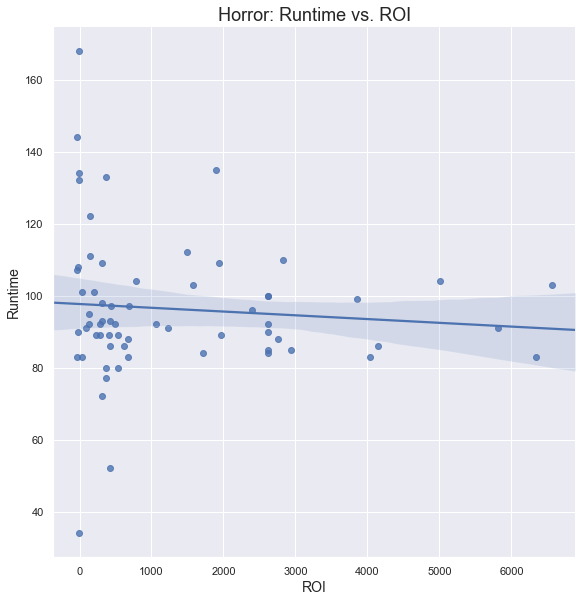

In [56]:
plot =sns.lmplot('roi','runtime_minutes',data = runtime_horror_df, height=8, truncate=False, fit_reg=True);
plt.title('Horror: Runtime vs. ROI',fontsize=18);
plt.xlabel('ROI', fontsize=14);
plt.ylabel('Runtime', fontsize=14);

## Horror: Avg. ROI by Season
This figure shows the ROI categorized by season for Horror movies. Counterintuitively, the season with the highest ROI for Horror movies is Spring then Fall. 

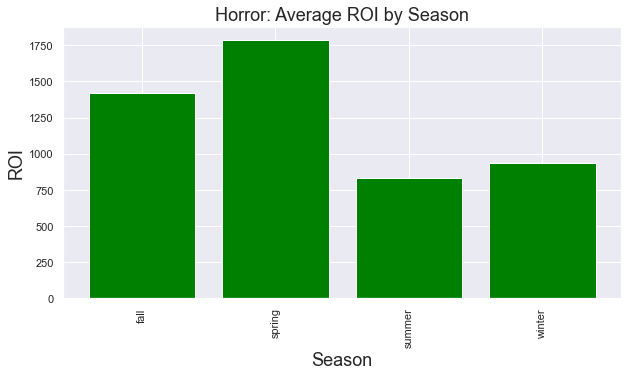

In [57]:
# Create bar plot using MatPltLib
y = roi_by_season
x = y.index

figure, ax = plt.subplots(figsize = (10,5))

# Set Labels
ax.set_title('Horror: Average ROI by Season', fontsize=18)
ax.set_xlabel('Season', fontsize=18)
ax.set_ylabel('ROI', fontsize=18)
plt.xticks(rotation=90)

# Plot
ax.bar(x, y, color='green');

## Horror: Runtime vs. ROI
This figure plots runtime against return on investment. There is a slight negative correlation, indicating that Horror movies with a higher ROI tend to have lower runtime.

/Users/ChristianTsui/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


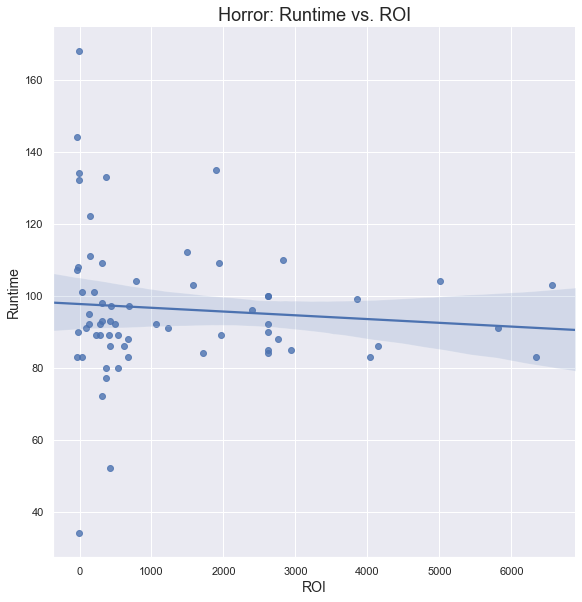

In [58]:
plot =sns.lmplot('roi','runtime_minutes',data = runtime_horror_df, height=8, truncate=False, fit_reg=True);
plt.title('Horror: Runtime vs. ROI',fontsize=18);
plt.xlabel('ROI', fontsize=14);
plt.ylabel('Runtime', fontsize=14);

# Question 2 Conclusion:

# Question 3: Studios and Production Budget of Successful Movies?
This question explores the competitive landscape of the movie production industry. By looking at market positioning and movie production strategy, Microsoft can use these insights to see where it can take advantage in the industry.

## Method:

### Construct Studios, Budget, ROI Dataframe

In [59]:
studios_df = pd.read_csv(gross_csv)
studios_df['foreign_gross'] = studios_df['foreign_gross'].str.replace(',','').astype(float)
studios_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   float64
 4   year            3387 non-null   int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 132.4+ KB


In [60]:
studios_df['total_gross'] = studios_df['domestic_gross'] + studios_df['foreign_gross']

In [61]:
studios_df.head(3)

,title,studio,domestic_gross,foreign_gross,year,total_gross
0,Toy Story 3,BV,415000000.0,652000000.0,2010,1.067000e+09
1,Alice in Wonderland (2010),BV,334200000.0,691300000.0,2010,1.025500e+09
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000.0,2010,9.603000e+08


In [62]:
studios_grouped = studios_df.groupby('studio')['total_gross'].sum().sort_values(ascending=False)

In [63]:
budgets_clean.rename(columns = {'movie':'title'}, inplace=True)

In [64]:
studios_budget = studios_df.merge(budgets_clean, on='title', how='left')

In [65]:
studios_budget.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3396 entries, 0 to 3395
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   title                3396 non-null   object        
 1   studio               3391 non-null   object        
 2   domestic_gross_x     3368 non-null   float64       
 3   foreign_gross        2044 non-null   float64       
 4   year                 3396 non-null   int64         
 5   total_gross          2016 non-null   float64       
 6   release_date         1247 non-null   datetime64[ns]
 7   production_budget    1247 non-null   float64       
 8   domestic_gross_y     1247 non-null   float64       
 9   international_gross  1247 non-null   float64       
 10  worldwide_gross      1247 non-null   float64       
 11  roi                  1247 non-null   float64       
dtypes: datetime64[ns](1), float64(8), int64(1), object(2)
memory usage: 344.9+ KB


In [66]:
studios_budget.dropna(inplace=True)

In [67]:
studios_budget.drop_duplicates(subset='title', inplace=True)

In [68]:
studios_budget.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1076 entries, 0 to 3280
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   title                1076 non-null   object        
 1   studio               1076 non-null   object        
 2   domestic_gross_x     1076 non-null   float64       
 3   foreign_gross        1076 non-null   float64       
 4   year                 1076 non-null   int64         
 5   total_gross          1076 non-null   float64       
 6   release_date         1076 non-null   datetime64[ns]
 7   production_budget    1076 non-null   float64       
 8   domestic_gross_y     1076 non-null   float64       
 9   international_gross  1076 non-null   float64       
 10  worldwide_gross      1076 non-null   float64       
 11  roi                  1076 non-null   float64       
dtypes: datetime64[ns](1), float64(8), int64(1), object(2)
memory usage: 109.3+ KB


In [69]:
studios_budget = studios_budget.loc[:,['studio','production_budget','worldwide_gross','roi']]

In [70]:
studios_budget.rename(columns={'worldwide_gross':'total_gross'},inplace=True)

In [71]:
studios_budget.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1076 entries, 0 to 3280
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   studio             1076 non-null   object 
 1   production_budget  1076 non-null   float64
 2   total_gross        1076 non-null   float64
 3   roi                1076 non-null   float64
dtypes: float64(3), object(1)
memory usage: 42.0+ KB


In [72]:
# There are 79 distinct studios in this dataset
studios_budget.value_counts('studio')

studio
Uni.        115
Fox         107
WB           99
Sony         73
Par.         71
           ... 
Neon          1
First         1
OMNI/FSR      1
FCW           1
3D            1
Length: 79, dtype: int64

In [73]:
x = studios_budget.groupby(['studio'])['production_budget'].mean().reset_index()
avg_budget = pd.DataFrame(x)

In [74]:
y = studios_budget.groupby(['studio'])['roi'].mean().reset_index()
avg_roi = pd.DataFrame(y)

In [75]:
studios_grouped = avg_budget.merge(avg_roi, on='studio', how='outer')

In [76]:
studios_df_plt = studios_grouped.sort_values('production_budget', ascending=False)[:25]

### Construct Studio Total Gross Genre Breakdown Dataframe

In [77]:
# Merging Studios with Genre
studios_df.head(3)

,title,studio,domestic_gross,foreign_gross,year,total_gross
0,Toy Story 3,BV,415000000.0,652000000.0,2010,1.067000e+09
1,Alice in Wonderland (2010),BV,334200000.0,691300000.0,2010,1.025500e+09
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000.0,2010,9.603000e+08


In [78]:
imdb_raw = imdb_basics.rename(columns = {'primary_title':'title'})
imdb_raw = imdb_raw.drop(['movie_id','original_title','start_year','runtime_minutes','genres'], axis=1)
imdb_raw.head(3)

,title,main_genre
0,Sunghursh,Action
1,One Day Before the Rainy Season,Biography
2,The Other Side of the Wind,Drama


In [79]:
# Merge imdb and studio
studio_imdb = studios_df.merge(imdb_raw, on='title', how='left')

In [80]:
studio_imdb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3968 entries, 0 to 3967
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3968 non-null   object 
 1   studio          3963 non-null   object 
 2   domestic_gross  3934 non-null   float64
 3   foreign_gross   2392 non-null   float64
 4   year            3968 non-null   int64  
 5   total_gross     2358 non-null   float64
 6   main_genre      3185 non-null   object 
dtypes: float64(3), int64(1), object(3)
memory usage: 248.0+ KB


In [81]:
studio_imdb.drop_duplicates(subset=['title'],inplace=True)

In [82]:
studio_imdb.dropna(inplace=True)

In [83]:
studio_imdb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1545 entries, 0 to 3925
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           1545 non-null   object 
 1   studio          1545 non-null   object 
 2   domestic_gross  1545 non-null   float64
 3   foreign_gross   1545 non-null   float64
 4   year            1545 non-null   int64  
 5   total_gross     1545 non-null   float64
 6   main_genre      1545 non-null   object 
dtypes: float64(3), int64(1), object(3)
memory usage: 96.6+ KB


In [84]:
studio_imdb.head()

,title,studio,domestic_gross,foreign_gross,year,total_gross,main_genre
0,Toy Story 3,BV,415000000.0,652000000.0,2010,1.067000e+09,Adventure
3,Inception,WB,292600000.0,535700000.0,2010,8.283000e+08,Action
4,Shrek Forever After,P/DW,238700000.0,513900000.0,2010,7.526000e+08,Adventure
5,The Twilight Saga: Eclipse,Sum.,300500000.0,398000000.0,2010,6.985000e+08,Adventure
6,Iron Man 2,Par.,312400000.0,311500000.0,2010,6.239000e+08,Action


In [85]:
studio_gross = studio_imdb.groupby(['studio','main_genre'])['total_gross'].sum()

In [86]:
studio_gross = studio_gross.reset_index()

In [87]:
studio_gross.groupby(['studio'])['total_gross'].sum()

studio
3D       1.600000e+07
A24      4.090443e+08
AF       4.100000e+06
AGF      1.768000e+05
AR       5.805000e+07
             ...     
WOW      4.940000e+04
Wein.    3.492561e+09
Yash     2.910045e+08
Zee      1.671000e+06
Zeit.    1.265420e+07
Name: total_gross, Length: 147, dtype: float64

# Question 3 Analysis:

## Top 25 Studios by Average Production Budget
This figure visualizes the average production budget of different studios sorted by total gross revenue. The purpose is to visualize the competitive landscape and get an idea for the resources Microsoft would be allocating towards movie production.

/Users/ChristianTsui/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



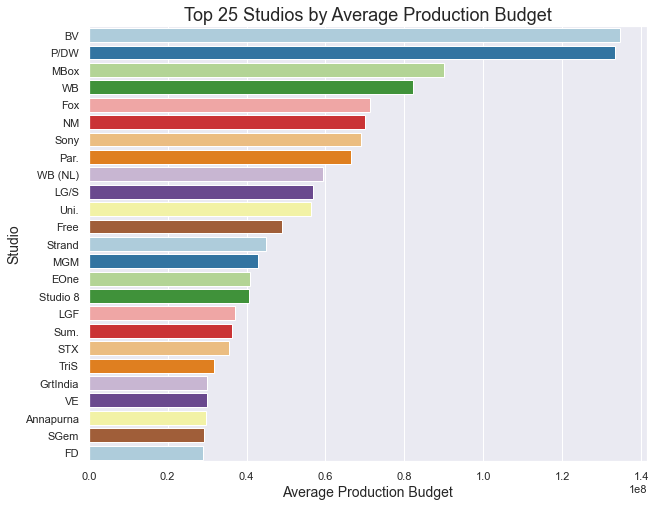

In [90]:
# Format Plot
sns.set(rc={'figure.figsize':(10,8)})
plot = sns.barplot('production_budget','studio' , data = studios_df_plt, order= studios_df_plt['studio'], palette='Paired');

# Set Labels
plot.set_title('Top 25 Studios by Average Production Budget', fontsize=18);
plt.xlabel('Average Production Budget', fontsize=14);
plt.ylabel('Studio', fontsize=14);

# Question 3 Conclusion:
Based on the competitive landscape, Microsoft should tailor its strategy towards where it sees fit. Since Microsoft would be just entering the movie production space, I suggest producing movies with a lower production budget.